In [28]:
%load_ext autoreload
%autoreload 2
import os
import glob
import cv2

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import json  # Added to initialize the setting in Jupyter Notebook-by Mingyang
import easydict  # Added to initialize the setting in Jupyter Notebook-by Mingyang
import random
import numpy as np
import nltk
import string
from PIL import Image
from pathlib import Path

from geneva.models.models import INFERENCE_MODELS
from geneva.data.datasets import DATASETS
from geneva.evaluation.evaluate import Evaluator
from geneva.utils.config import keys, parse_config
from geneva.utils.visualize import VisdomPlotter
from geneva.models.models import MODELS
from geneva.data import codraw_dataset
from geneva.data import clevr_dataset
from geneva.data import gandraw_dataset
from geneva.evaluation.seg_scene_similarity_score import report_gandraw_eval_result
from geneva.utils.config import keys
from math import sqrt

import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from torchvision import transforms

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
class UnNormalize(object):

    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
class AverageMeter(object):
    """Taken from https://github.com/pytorch/examples/blob/master/imagenet/main.py"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n

    def compute_mean(self):
        self.avg = self.sum / self.count
        
class GanDraw_Teller():
    def __init__(self, cfg, pretrained_model_path=None, iteration=6000):
        self.cfg = cfg
        self.cfg.batch_size = 1
        #Load the Dataset
        dataset_path = cfg.test_dataset
        self.dataset = DATASETS[cfg.dataset](path="/home/zmykevin/CoDraw_Gaugan/data/GanDraw/data_full/gandraw_hdf5/gandraw_test.h5",
                                             cfg=cfg,
                                             img_size=cfg.img_size)
        self.dataloader = DataLoader(self.dataset,
                                     batch_size=cfg.batch_size,
                                     shuffle=False,
                                     num_workers=cfg.num_workers,
                                     drop_last=True)
        self.cfg.vocab_size = self.dataset.vocab_size
        self.model = INFERENCE_MODELS[cfg.gan_type](cfg)
        #load the pretrained_model
        if pretrained_model_path is not None:
            self.model.load_model('/'.join([pretrained_model_path,'snapshot_{}.pth'.format(iteration)]))
            
        self.iterations = len(self.dataset) // cfg.batch_size
        self.current_iteration=iteration
        #define the collate_fn
        self.dataloader.collate_fn = gandraw_dataset.collate_data
        self.cross_entropy_loss = nn.CrossEntropyLoss().cuda()
        self.output_dir = self.cfg.results_path
        
        self.image_transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
        
        self.unorm = UnNormalize(mean=(0.5, 0.5, 0.5), std=(
                                 0.5, 0.5, 0.5))
        #self.unk_embedding = np.load("unk_embedding.npy")
        self.word2index = self.dataset.word2index
        self.index2word = self.dataset.index2word
        self.previous_output_utt = None
    def generate_utt(self, input_img=None, input_utt=None):
        #concate output_utt and  input_utt
        if input_img is not None and input_utt is not None:
            input_img = self.load_img(input_img)
            input_utt_ids, input_utt_len = self.utt2ids(input_utt)
        else:
            input_utt_ids = None
            input_utt_len = None
        output_utt, stop =  self.model.generate_utt(input_img,input_utt_ids, input_utt_len, self.word2index, self.index2word)
        #update self.previous_output_utt
        self.previous_output_utt = output_utt
        return  output_utt, stop
    def load_img(self, input_img, resize_wh=128):
        r"""
        input_img should be a three dimensional numpy matrix
        """
        if input_img.shape[0] > resize_wh:
            input_img = cv2.resize(input_img, (resize_wh, resize_wh), interpolation=cv2.INTER_AREA)
        
        processed_input_img = self.image_transform(input_img).numpy()
        processed_input_img = np.expand_dims(processed_input_img, axis=0)
        return torch.FloatTensor(processed_input_img)
    def utt2ids(self, input_text):
        #Tokenize the input_text
        teller_text_tokens = ['<teller>'] + nltk.word_tokenize(self.previous_output_utt)
        drawer_text_tokens = ['<drawer>'] + nltk.word_tokenize(input_text)
        all_tokens = teller_text_tokens + drawer_text_tokens
        all_tokens_ids = [0] + [self.word2index.get(x, self.word2index['<unk>']) for x in all_tokens if x!= "<teller>" and x!= "<drawer>"]+[1]
        all_tokens_len = len(all_tokens_ids)
        
        turn_teller_drawer_ids = np.array(all_tokens_ids)
        turn_teller_drawer_ids = np.expand_dims(turn_teller_drawer_ids, axis=0)
        turn_teller_drawer_ids_len = np.ones((1))*all_tokens_len
        
        return torch.LongTensor(turn_teller_drawer_ids), torch.LongTensor(turn_teller_drawer_ids_len)
    def reset_teller(self):
        self.previous_output_utt = None
        self.model.reset_teller()
    def import_tgt_img(self, tgt_img):
        tgt_image = self.load_img(tgt_img)
        self.model.import_tgt_img(tgt_image)


In [21]:
config_file = "example_args/gandraw_teller_args.json"
with open(config_file, 'r') as f:
    cfg = json.load(f)

cfg = easydict.EasyDict(cfg)
cfg.result_path = 'gandraw_teller_result'
n_gpu = torch.cuda.device_count()
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(cfg.seed)
teller = GanDraw_Teller(cfg, pretrained_model_path="logs/gandraw/teller/gandraw_teller_fulldata")

In [29]:
#teller.run_test()
teller.reset_teller()

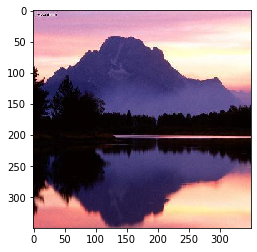

In [30]:
sample_tgt_img_path = "/home/zmykevin/CoDraw_Gaugan/data/GanDraw/data_full/target_images_org/5.jpg"
sample_tgt_img = cv2.imread(sample_tgt_img_path)
sample_tgt_img = cv2.cvtColor(sample_tgt_img, cv2.COLOR_BGR2RGB)
import matplotlib.pyplot as plt
plt.imshow(sample_tgt_img)
plt.show()

In [31]:
#print(sample_tgt_img.dtype)
#load the target image
teller.import_tgt_img(sample_tgt_img)

In [32]:
#generate the image caption
teller.generate_utt()

('bottom fourth is water then half tree from center left to right', False)

In [33]:
sample_dialog = [
                {
                    "drawer": "how's this",
                    "drawer_label": "Request_Correction",
                    "image_semantic": "image_data/b97d9792.png",
                    "image_synthetic": "image_data/44819c73.jpg",
                    "teller": "bottom half is water. line of trees above that. one big mountain with peak in the center of image. more trees on the left side",
                    "teller_label": "Describe_Image"
                },
                {
                    "drawer": "thanks",
                    "drawer_label": "Other",
                    "image_semantic": "image_data/71083e09.png",
                    "image_synthetic": "image_data/579a7ea7.jpg",
                    "teller": "looks good. more jagged mountain",
                    "teller_label": "Correct_Drawing"
                },
                {
                    "drawer": "what about now?",
                    "drawer_label": "Request_Correction",
                    "image_semantic": "image_data/6de35eab.png",
                    "image_synthetic": "image_data/4229f340.jpg",
                    "teller": "more trees",
                    "teller_label": "Correct_Drawing"
                }
            ]

In [34]:
data_path = "/home/zmykevin/CoDraw_Gaugan/data/GanDraw/data_full/"
for turn in sample_dialog:
    drawer_utt = turn["drawer"]
    drawer_img = cv2.imread('/'.join([data_path,turn['image_synthetic']]))
    drawer_img = cv2.cvtColor(sample_tgt_img, cv2.COLOR_BGR2RGB)
    #generate teller_utt
    teller_utt = teller.generate_utt(drawer_img, drawer_utt)
    print(teller_utt)
    

('better now there is a small line of trees in between the mountains and above the trees on the right side', False)
('make them the right though in the right but not touching the peak', False)
('thats good now add a small blob of trees in the middle of the picture in the bottom right hand corner', False)
